# Time Series

Import functions

In [2]:
from funcs import * # funcs include functions used across scripts
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Read in the data

In [3]:
o = read_all('OPTICAL') # optical data
inl = read_all('InletFlag') # inlet flag
a = read_all('AMS') # ams
mn = read_all('MetNav') # met nav

In [4]:
retrieval_paths = sorted(glob.glob('../data/v2/*/*/*.csv'))
retrieval_list = []
for i in range(0, len(retrieval_paths)):
    retrieval_list.append(pd.read_csv(retrieval_paths[i], parse_dates=['Start_Date_Time_UTC', 'Stop_Date_Time_UTC']))
r = pd.concat(retrieval_list).reset_index(drop=True)

Code used to plot a variable over the course of the entire campaign

In [5]:
def remove_nan(d, var):
    return d[np.isfinite(d[var])].reset_index(drop=True)

In [6]:
def add_line(x,y):
    m , b = np.polyfit(x, y, 1)
    x2 = np.linspace(x.min(), x.max(), 1000)
    y2 = x2*m + b
    return x2,y2

In [7]:
def var_plot(d, var, var_label, time_index = 'Time_Mid', hline = None):
    fig,ax = plt.subplots(figsize=(9,3))

    d_small = d[[time_index, var]] # only using columns of interest for resampling

    # resample data
    d_resamp = d_small.resample('2h', on=time_index).quantile(.50).reset_index()
    d_resamp_75 = d_small.resample('2h', on=time_index).quantile(.75).reset_index()
    d_resamp_25 = d_small.resample('2h', on=time_index).quantile(.25).reset_index()

    # remove nan
    d_resamp = remove_nan(d_resamp, var)
    d_resamp_25 = remove_nan(d_resamp_25, var)
    d_resamp_75 = remove_nan(d_resamp_75, var)

    # add text to plot displaying to total number of points
    count_text = 'N = ' + str(len(d[np.isfinite(d[var])][var]))
    ax.text(.99, .98, count_text, ha='right', va='top', transform=ax.transAxes)

    # plot the resampled data with error bars
    ax.errorbar(d_resamp.index, d_resamp[var], yerr=(d_resamp_75[var]-d_resamp[var], d_resamp[var]-d_resamp_25[var]), c='black', fmt='.')

    # add a trend line
    x,y = add_line(d_resamp.index,d_resamp[var])
    plt.plot(x,y, ls = '--', c='red')

    # mark on figure changes in day
    day_changes = d_resamp[time_index].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    for i in range(0,len(flight_ind)):
        ax.axvline(flight_ind[i], 0, 1, alpha=.2, c='black')
        date = d_resamp.loc[flight_ind[i]][time_index]
        day_ticks.append(str(date.month) + '/' + str(date.day))

    # add a horizontal reference line
    if hline is not None:
        ax.axhline(y=hline, c='black', ls='--', alpha=.2)

    ax.set_xticks(flight_ind)
    ax.set_xticklabels(day_ticks, rotation=90)
    ax.set_xlabel('Date [M/DD]')
    ax.set_ylabel(var_label)

    fig.tight_layout()
    fig.savefig('../figures/overview_ts_'+var+'.png', dpi=300)

## Plotting overview figures

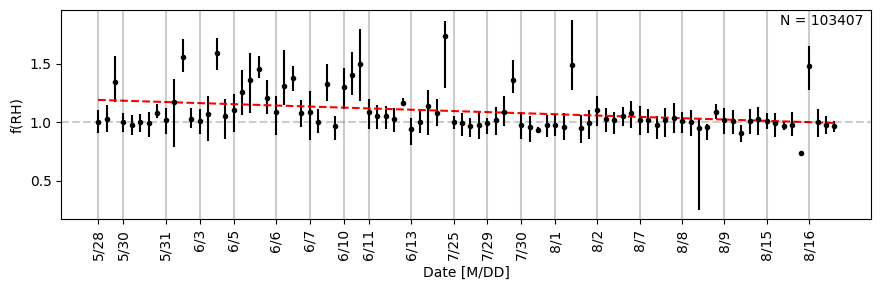

In [8]:
var_plot(o,'fRH550_RH20to80', 'f(RH)', hline = 1)

In [9]:
ams_keys = ['Org_Ave_IsoK_STP','SO4_Ave_IsoK_STP','NO3_Ave_IsoK_STP','NH4_Ave_IsoK_STP','Chl_Ave_IsoK_STP']
a['tot'] = a[ams_keys].sum(axis=1)
a = a[a['tot']>.4]
a['OMF'] = a['Org_Ave_IsoK_STP']/a['tot']
a['SMF'] = a['SO4_Ave_IsoK_STP']/a['tot']

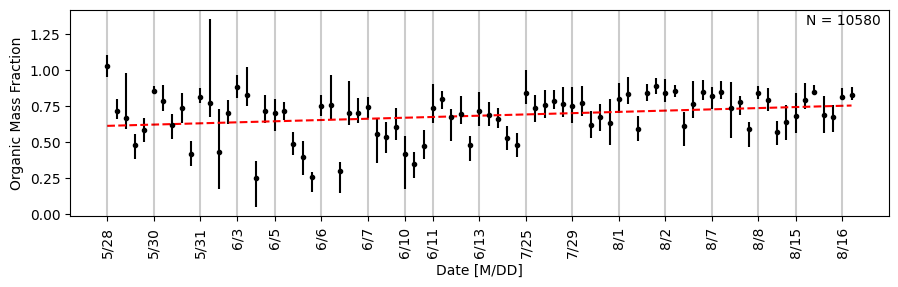

In [10]:
var_plot(a, 'OMF', 'Organic Mass Fraction')

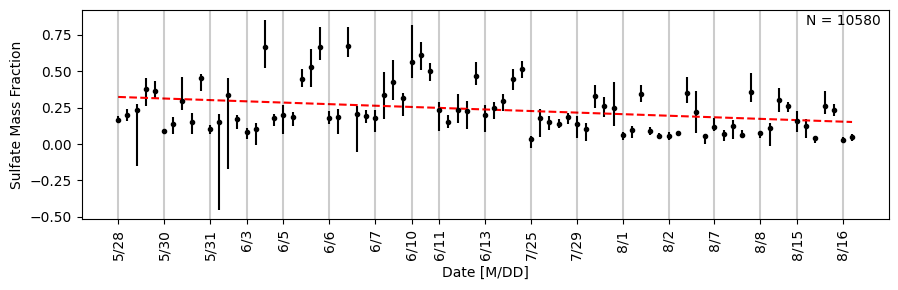

In [11]:
var_plot(a, 'SMF', 'Sulfate Mass Fraction')

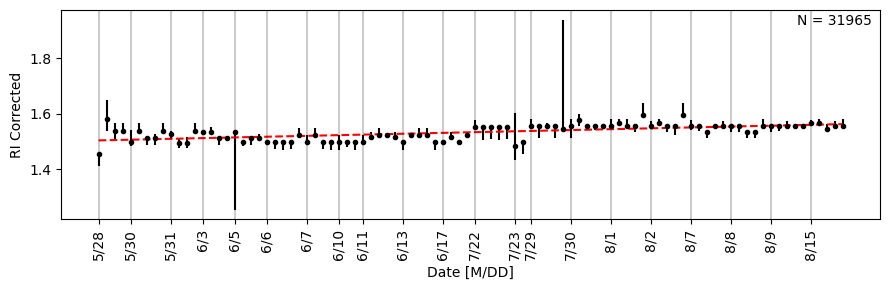

In [12]:
var_plot(r, 'RI_corr', 'RI Corrected', time_index='Start_Date_Time_UTC')

In [13]:
r_dps = []
dps = sorted(r['SEMS_Dp'].unique())
for i in range(0,len(dps)):
    #r_dps.append(r[(np.abs(r['RH']-85)<5)& (r['SEMS_Dp']==dps[i])])
    r_dps.append(r[(r['RH']>75) & (r['SEMS_Dp']==dps[i])])

In [14]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    var_plot(r_dps[i], 'GF_raw_'+d_label, 'GF Raw @' + d_label + ' nm', time_index='Start_Date_Time_UTC', hline = 1)
    plt.close()

## Plotting flight specific figures

In [24]:
def var_plot_single_flight(d, var, var_label, time_index = 'Time_Mid', hline = None):

    d_small = d[[time_index, var]] # only using columns of interest for resampling

    # resample data
    d_resamp = d_small.resample('10min', on=time_index).quantile(.50).reset_index()
    d_resamp_75 = d_small.resample('10min', on=time_index).quantile(.75).reset_index()
    d_resamp_25 = d_small.resample('10min', on=time_index).quantile(.25).reset_index()

    # remove nan
    d_resamp = remove_nan(d_resamp, var)
    d_resamp_25 = remove_nan(d_resamp_25, var)
    d_resamp_75 = remove_nan(d_resamp_75, var)

    # mark on figure changes in day
    day_changes = d_resamp[time_index].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    file_date = []
    for i in range(0,len(flight_ind)):
        date = d_resamp.loc[flight_ind[i]][time_index]
        day_ticks.append(str(date.month) + '/' + str(date.day))
        file_date.append(f"{date.year}_{date.month:02}_{date.day:02}")


        

        if i < len(flight_ind)-1:
            end_ind = flight_ind[i+1]
        else:
            end_ind = len(d_resamp)
        
        d_resamp_sub = d_resamp.loc[flight_ind[i]:end_ind-1]
        d_resamp_25_sub = d_resamp_25.loc[flight_ind[i]:end_ind-1]
        d_resamp_75_sub = d_resamp_75.loc[flight_ind[i]:end_ind-1]
        
        fig,ax = plt.subplots(figsize=(9,3))

        # plot the resampled data with error bars
        ax.errorbar(d_resamp_sub[time_index], d_resamp_sub[var], yerr=(d_resamp_75_sub[var]-d_resamp_sub[var], d_resamp_sub[var]-d_resamp_25_sub[var]), c='black', fmt='.')
        ax.xaxis.set_major_locator(mdates.HourLocator())  # Set major ticks to days
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Set date format
        ax.set_title(day_ticks[i])
        
        # add a horizontal reference line
        if hline is not None:
            ax.axhline(y=hline, c='black', ls='--', alpha=.2)

        ax.set_xlabel('Hour [UTC]')
        ax.set_ylabel(var_label)

        fig.tight_layout()
        fig.savefig('../figures/ts_'+ var + '_' + file_date[i]+'.png', dpi=300)
        plt.close()

In [25]:
var_plot_single_flight(o,'fRH550_RH20to80', 'f(RH)', hline = 1)
var_plot_single_flight(a, 'OMF', 'Organic Mass Fraction')
var_plot_single_flight(a, 'SMF', 'Sulfate Mass Fraction')
var_plot_single_flight(r, 'RI_corr', 'RI Corrected', time_index='Start_Date_Time_UTC')

In [16]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    var_plot_single_flight(r_dps[i], 'GF_raw_'+d_label, 'GF Raw @' + d_label + ' nm', time_index='Start_Date_Time_UTC', hline = 1)

/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

Merge all datasets into a single dataframe

In [68]:
def var_plot_single_flight_ax(ax, d, var, var_label, time_index = 'Time_Mid', hline = None):

    d_small = d[[time_index, var]] # only using columns of interest for resampling
    if len(d_small)>0:
        # resample data
        d_resamp = d_small.resample('10min', on=time_index).quantile(.50).reset_index()
        d_resamp_75 = d_small.resample('10min', on=time_index).quantile(.75).reset_index()
        d_resamp_25 = d_small.resample('10min', on=time_index).quantile(.25).reset_index()

        # remove nan
        d_resamp = remove_nan(d_resamp, var)
        d_resamp_25 = remove_nan(d_resamp_25, var)
        d_resamp_75 = remove_nan(d_resamp_75, var)

        # plot the resampled data with error bars
        ax.errorbar(d_resamp[time_index], d_resamp[var], yerr=(d_resamp_75[var]-d_resamp[var], d_resamp[var]-d_resamp_25[var]), c='black', fmt='.')
        #ax.xaxis.set_major_locator(mdates.HourLocator())  # Set major ticks to days
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Set date format
        #ax.set_title(day_ticks[i])

        ax.set_ylabel(var_label)

        # add a horizontal reference line
        if hline is not None:
            ax.axhline(y=hline, c='black', ls='--', alpha=.2)


In [84]:
def var_plot_single_flight_multi_panel(d, var, var_label, time_index = 'Time_Mid', hline = None):

    d_small = d[[time_index, var]] # only using columns of interest for resampling

    # resample data
    d_resamp = d_small.resample('10min', on=time_index).quantile(.50).reset_index()
    d_resamp_75 = d_small.resample('10min', on=time_index).quantile(.75).reset_index()
    d_resamp_25 = d_small.resample('10min', on=time_index).quantile(.25).reset_index()

    # remove nan
    d_resamp = remove_nan(d_resamp, var)
    d_resamp_25 = remove_nan(d_resamp_25, var)
    d_resamp_75 = remove_nan(d_resamp_75, var)

    # mark on figure changes in day
    day_changes = d_resamp[time_index].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    file_date = []
    for i in range(0,len(flight_ind)):
        date = d_resamp.loc[flight_ind[i]][time_index]
        day_ticks.append(str(date.month) + '/' + str(date.day))
        file_date.append(f"{date.year}_{date.month:02}_{date.day:02}")
        
        if i < len(flight_ind)-1:
            end_ind = flight_ind[i+1]
        else:
            end_ind = len(d_resamp)+1

        if end_ind-2 > 0:
            
            d_resamp_sub = d_resamp.loc[flight_ind[i]:end_ind-1]
            d_resamp_25_sub = d_resamp_25.loc[flight_ind[i]:end_ind-1]
            d_resamp_75_sub = d_resamp_75.loc[flight_ind[i]:end_ind-1]

            st_t = d_resamp.loc[flight_ind[i]][time_index]
            end_t = d_resamp.loc[end_ind-2][time_index]

            fig,axes = plt.subplots(5, figsize=(9,9), sharex=True)


            # plot the resampled data with error bars
            axes[0].errorbar(d_resamp_sub[time_index], d_resamp_sub[var], yerr=(d_resamp_75_sub[var]-d_resamp_sub[var], d_resamp_sub[var]-d_resamp_25_sub[var]), c='black', fmt='.')
            
            other_data = [a, o, mn]
            other_data_j = [0,0,1,2]
            other_keys = ['OMF', 'SMF', 'fRH550_RH20to80', 'GPS_Altitude']
            other_names = ['Organic Mass Fraction', 'Sulfate Mass Fraction', 'f(RH)', 'Altitude']
            other_time_index = ['Time_Mid', 'Time_Mid', 'Time_Mid', 'Time_Start']
            
            for j in range(0,len(other_data_j)):
                d_j = other_data[other_data_j[j]]
                t_i = other_time_index[j]
                d_j = d_j[(d_j[t_i] > st_t) & (d_j[t_i] < end_t)]
                var_plot_single_flight_ax(axes[j+1], d_j, other_keys[j], other_names[j], time_index = other_time_index[j])
            
            
            axes[4].xaxis.set_major_locator(mdates.HourLocator())  # Set major ticks to days
            axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Set date format
            axes[0].set_title(day_ticks[i])
            
            # add a horizontal reference line
            if hline is not None:
                axes[0].axhline(y=hline, c='black', ls='--', alpha=.2)

            axes[4].set_xlabel('Hour [UTC]')
            axes[0].set_ylabel(var_label)

            fig.tight_layout()
            fig.savefig('../figures/ts_mp_'+ var + '_' + file_date[i]+'.png', dpi=300)
            plt.close()

In [70]:
var_plot_single_flight_multi_panel(r, 'RI_corr', 'RI', time_index='Start_Date_Time_UTC')

In [85]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    var_plot_single_flight_multi_panel(r_dps[i], 'GF_raw_'+d_label, 'GF Raw @' + d_label + ' nm', time_index='Start_Date_Time_UTC', hline = 1)

0 12
0 10
10 16
0 14
14 19
19 28
28 30
30 43
43 53
53 66
66 80
80 115
115 128
128 156
156 197
197 217
217 235
235 266
266 299
299 320
320 343
343 366
366 383
0 21
21 42
42 53
53 61
61 83
83 130
130 163
163 193
193 240
240 282
282 313
313 357
357 400
400 432
432 471
471 519
519 556
556 593
593 635
635 670
0 16
16 20
20 28
28 30
30 42
42 52
52 66
66 79
79 118
118 124
124 147
147 186
186 187


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


187 201
201 216
216 240
240 263
263 277
277 286
286 301
301 312
0 6


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


6 7


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


7 10


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

10 12
0 6
6 14
14 15


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


15 28
28 35
35 45
45 57
57 93
93 102
102 120
120 159
159 172
172 190
190 222
222 249
249 261
261 269
269 287
287 305
1 4


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

4 9


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


9 19
19 32
32 39
39 40


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


40 41


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


41 44


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

44 49
49 53
53 55
55 65
65 70
2 4


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


0 5
5 12
12 14
14 15


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


15 26
26 35
35 40
40 41


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


41 42


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


42 43


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


43 45
45 47
47 48


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


48 50
50 55
1 3
3 6


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

1 4


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

2 5


/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series

5 7


In [18]:
def var_plot_single_flight_ax_raw(ax, d, var, var_label, time_index = 'Time_Mid', hline = None):

    d_small = d[[time_index, var]] # only using columns of interest for resampling
    if len(d_small)>0:
        # resample data
        d_resamp = d_small.resample('10min', on=time_index).quantile(.50).reset_index()
        d_resamp_75 = d_small.resample('10min', on=time_index).quantile(.75).reset_index()
        d_resamp_25 = d_small.resample('10min', on=time_index).quantile(.25).reset_index()

        # remove nan
        d_resamp = remove_nan(d_resamp, var)
        d_resamp_25 = remove_nan(d_resamp_25, var)
        d_resamp_75 = remove_nan(d_resamp_75, var)

        # plot the resampled data with error bars
        ax.errorbar(d_resamp[time_index], d_resamp[var], yerr=(d_resamp_75[var]-d_resamp[var], d_resamp[var]-d_resamp_25[var]), c='black', fmt='.')
        #ax.xaxis.set_major_locator(mdates.HourLocator())  # Set major ticks to days
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Set date format
        #ax.set_title(day_ticks[i])

        ax.set_ylabel(var_label)

        # add a horizontal reference line
        if hline is not None:
            ax.axhline(y=hline, c='black', ls='--', alpha=.2)


def var_plot_single_flight_multi_panel_raw(d, var, var_label, time_index = 'Time_Mid', hline = None):

    d_small = d[[time_index, var]] # only using columns of interest for resampling

    # resample data
    d_resamp = d_small#.resample('10min', on=time_index).quantile(.50).reset_index()
    #d_resamp_75 = d_small.resample('10min', on=time_index).quantile(.75).reset_index()
    #_resamp_25 = d_small.resample('10min', on=time_index).quantile(.25).reset_index()

    # remove nan
    d_resamp = remove_nan(d_resamp, var)
    #d_resamp_25 = remove_nan(d_resamp_25, var)
    #d_resamp_75 = remove_nan(d_resamp_75, var)

    # mark on figure changes in day
    day_changes = d_resamp[time_index].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    file_date = []
    for i in range(0,len(flight_ind)):
        date = d_resamp.loc[flight_ind[i]][time_index]
        day_ticks.append(str(date.month) + '/' + str(date.day))
        file_date.append(f"{date.year}_{date.month:02}_{date.day:02}")
        
        if i < len(flight_ind)-1:
            end_ind = flight_ind[i+1]
        else:
            end_ind = len(d_resamp)+1

        if end_ind-2 > 0:
            
            d_resamp_sub = d_resamp.loc[flight_ind[i]:end_ind-1]
            #d_resamp_25_sub = d_resamp_25.loc[flight_ind[i]:end_ind-1]
            #d_resamp_75_sub = d_resamp_75.loc[flight_ind[i]:end_ind-1]

            st_t = d_resamp.loc[flight_ind[i]][time_index]
            end_t = d_resamp.loc[end_ind-2][time_index]

            fig,axes = plt.subplots(5, figsize=(9,9), sharex=True)


            # plot the resampled data with error bars
            #axes[0].errorbar(d_small[time_index], d_resamp_sub[var], yerr=(d_resamp_75_sub[var]-d_resamp_sub[var], d_resamp_sub[var]-d_resamp_25_sub[var]), c='black', fmt='.')
            axes[0].scatter(d_resamp_sub[time_index], d_resamp_sub[var], c='black')
            
            other_data = [a, o, mn]
            other_data_j = [0,0,1,2]
            other_keys = ['OMF', 'SMF', 'fRH550_RH20to80', 'GPS_Altitude']
            other_names = ['Organic Mass Fraction', 'Sulfate Mass Fraction', 'f(RH)', 'Altitude']
            other_time_index = ['Time_Mid', 'Time_Mid', 'Time_Mid', 'Time_Start']
            
            for j in range(0,len(other_data_j)):
                d_j = other_data[other_data_j[j]]
                t_i = other_time_index[j]
                d_j = d_j[(d_j[t_i] > st_t) & (d_j[t_i] < end_t)]
                var_plot_single_flight_ax_raw(axes[j+1], d_j, other_keys[j], other_names[j], time_index = other_time_index[j])
            
            
            axes[4].xaxis.set_major_locator(mdates.HourLocator())  # Set major ticks to days
            axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Set date format
            axes[0].set_title(day_ticks[i])
            
            # add a horizontal reference line
            if hline is not None:
                axes[0].axhline(y=hline, c='black', ls='--', alpha=.2)

            axes[4].set_xlabel('Hour [UTC]')
            axes[0].set_ylabel(var_label)

            fig.tight_layout()
            fig.savefig('../figures/ts_mp_'+ var + '_' + file_date[i]+'_no_resmap.png', dpi=300)
            plt.close()

var_plot_single_flight_multi_panel_raw(r, 'RI_corr', 'RI', time_index='Start_Date_Time_UTC')

for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    var_plot_single_flight_multi_panel_raw(r_dps[i], 'GF_raw_'+d_label, 'GF Raw @' + d_label + ' nm', time_index='Start_Date_Time_UTC', hline = 1)

/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series